## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
import statsmodels.api as sm
from scipy.stats import norm

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv') 

In [3]:
# print the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
# return only rows' shape
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [6]:
# Since uts 0s and 1s, mean would be the right choice
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# Consists of 2 parts;

# 1. All treatments that are not new 
treat_not_new = df.query('group == "treatment" & landing_page != "new_page"')

# 2. All new that are not treatment
new_not_treat = df.query('group != "treatment" & landing_page == "new_page"')

# Sum both
len(treat_not_new) + len(new_not_treat)

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No columns have nans

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.drop(treat_not_new.index)
df2 = df2.drop(new_not_treat.index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# rows with duplicated ids 
df2[df2.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset='user_id', keep="first", inplace = True)

# Check it's deleted
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
# The same way as in df
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group'] =='control' ]['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group'] =='treatment' ]['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
len(df2[df2['landing_page'] =='new_page' ])/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**There's no sufficient evidence for the following reasons:**
1. The percentage of converting audiance (individual) in the control group is only **12.04%**
2. The percentage of converting audiance (individual) in the treatment group is only **11.89%**
3. note how the rates are similiar in both categories so there's no significant difference.
4. There's a class balance state between old and new pages (half and half) and about 300K observations so the results can be trusted.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**For a 5% confidence level:**

- Null Hypotheses: if (p-value<5%) , ( **$p_{new}$ <= $p_{old}$** )
- Alternative Hypotheses: if (p-value>=5%), ( **$p_{new}$ > $p_{old}$**) .


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
# It would be equal to p_new since case 2 null hypo 
# assumes both have "true" success rates equal to converted rate
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
# Lenghth of filtred df2 with new_page rows only
n_new = len(df2[df2['landing_page'] == "new_page"])

n_new

145310

d. What is $n_{old}$?

In [22]:
# Lenghth of filtred df2 again but with old_page rows only
n_old = len(df2[df2['landing_page'] == "old_page"])

n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

# Generates random samples from a binomial distribution
# with p_new as p-values and size of n_new
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17496

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

# Generates random samples from a binomial distribution
# with p_old as p-values and size of n_old
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17504

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

-8.4905540402469e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
# p_diffs = np.array([])
# for _ in range(10000):
#     new_page_converted = np.random.binomial(n_new, p_new)
#     old_page_converted = np.random.binomial(n_old, p_old)
#     p_diffs = np.append(p_diffs, ( new_page_converted / n_new ) - (old_page_converted / n_old ))


In [27]:
p_diffs = np.array([])
# for _ in range(10000):
new_page_converted = np.random.binomial(n_new, p_new, 10000) / n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_page_converted - old_page_converted


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

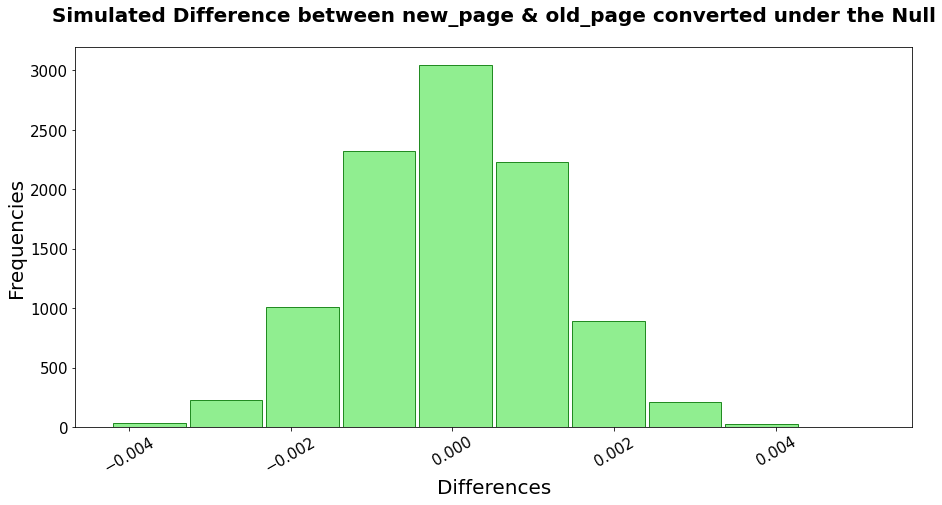

In [28]:
plt.figure(figsize = (15,7))
# mid = (plt.figure.subplotpars.right + plt.figure.subplotpars.left)/2
plt.title('Simulated Difference between new_page & old_page converted under the Null', fontsize = 20, pad=25, fontweight='bold')
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.xlabel("Differences", fontsize=20)
plt.ylabel("Frequencies", fontsize=20)
plt.hist(p_diffs, rwidth=0.95, color = "lightgreen", ec="forestgreen");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# original data from ab_data
df2_control = df2[df2['group'] == "control"]['converted']
df2_treatment = df2[df2['group'] == "treatment"]['converted']

# actual difference observed from df2
actual_obs_diff = df2_treatment.mean() - df2_control.mean()
actual_obs_diff

-0.0015782389853555567

In [30]:
# Calculate the propotion of the p_diffs that are greater than the actual difference observed in df2
print('The propotion of p_diffs that are greater than the actual difference is: ',(p_diffs > actual_obs_diff).mean()*100, '%')

The propotion of p_diffs that are greater than the actual difference is:  90.48 %


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

What we computed is the actual versus observed difference in means of converted old page and converted new page.
1. In scientific studies, this value is called the P-value and it represents the p-value of observing the statistic consedering the null hypo is true. 
2. In order to accept the null hypothesis, the p-val should be greater than the critical p-val (0.05 in our case).
3. our observed p-val (0.9048) exceeded the critical value so we fail to reject (hence we accept) the null hypothesis.
4. In coclusion, we cannot assume the new page converts more users than the old page. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
# df2_control, df2_treatment are already calculated before
# sum is equivelent to all rows with converted == 1 since it's only 0s and 1s
convert_old = df2_control.sum()
convert_new = df2_treatment.sum()

n_old = len(df2_control)
n_new = len(df2_treatment)

In [32]:
print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
#returns z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller', prop_var=False)
(z_score, p_value)

(1.3109241984234394, 0.9050583127590245)

In [34]:
# returns the critical z-value corresponding to 95% confidence 
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

1. The calculated z-score (1.31) has a lower value than the critical z-value (1.64)  
2. The calculated p-value (0.9051) is much higher than the critical p-value(0.05)
3. These observations conclude that we fail to reject (hence we accept) the null hypothesis. 
4. This conclusion supports our conclusions for parts j and k . 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

 - The conversion is either a yes or a no (Binary-like), so we will be using **Logistic Regression**.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Create the intercept col
df2['intercept'] = 1

# Create the dummy variable column
df2['ab_page'] = np.where(df2['group'] == 'control', 0, 1)

# print head to check
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Oct 2022   Pseudo R-squ.:               8.077e-06
Time:                        22:57:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

1. The p-value associated with **ab_page** from the smmary is 0.19. 
2. part-II is considered a one-tailed test, while log-reg is considered a two-tailed test

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- There could be other factors affecting the conversion rate so, considering other factors may give more precise and accurate results
- There could be some disadvantages like:
    * The model would be more complex.
    * We may need more data and columns which may not be easy most of times.
    * After collecting the data we may face class imbalannce problem that may affect the model's performance


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# value counts for unique countries of the users
countries_df['country'].value_counts()

# These results may be considered class imbalance and affect the results

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
# join the 2 dfs in one new df
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


### Create the necessary dummy variables

In [41]:
### Create dummy variables for each country (like categorical hot-encoding)
df_new[['CA','UK', 'US']]= pd.get_dummies(df_new['country'])
df_new.head(10)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0
909908,UK,2017-01-06 20:44:26.334764,treatment,new_page,0,1,1,0,1,0
811617,US,2017-01-02 18:42:11.851370,treatment,new_page,1,1,1,0,0,1
938122,US,2017-01-10 09:32:08.222716,treatment,new_page,1,1,1,0,0,1
887018,US,2017-01-06 11:09:40.487196,treatment,new_page,0,1,1,0,0,1


In [42]:
### Fit Your Linear Model And Obtain the Results
#### I removed CA from country to avoid class imbalance problems
model2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results2 = model2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [43]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 20 Oct 2022   Pseudo R-squ.:               2.323e-05
Time:                        22:58:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

From these results we obtain: 
* countries doesn't appear to have special influence on conversion since they all have significance values bigger than 0.05
* UK results (0.074) may be kinda intresting since they are a little close to 0.05

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
### Create interactions columns
# multiplication here may be used as an and gate
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,US_ab_page,UK_ab_page,CA_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [45]:
### Fit Your Linear Model And Obtain the Results (including interaction columns)
model3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])
results3 = model3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [46]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Oct 2022   Pseudo R-squ.:               3.482e-05
Time:                        22:59:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

* Still no Significance level of the new features exceeds the 0.05 so none of them proves direct effect on the conversion rate

<a id='conclusions'></a>
## Conclusions

To conclude, in this work we tried to study the effect of some factors on converting from some old page to another new page. 

To do so, we employed three different ways, or parts: 
    * Probability Statistical Analysis.
    * A/B testing (Hypothesis).
    * Logistic Regression Model Approach.
<br/><br/>
- For the probapility part we include: 
    * The rates of conversion in both treatment and control groups are almost similiar so, there's no significant difference.
<br/><br/>
- For the hypothesis part we include: 
    * The made observations of p and z values at different cases concluded that we fail to reject (hence we accept) the null hypothesis meaning there's no page better than the other.
    * These results supports the results from the probability part.
<br/><br/>
- For the Log-Reg model part: 
    * We trained te models 3 times on different enteries (features).
    * First on only ['intercept', 'ab_page'], second after including countries with them, last but not least after including countries we icluded another columns representing a relation between the page and the country ['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']    
    * All the 3 cases had a significance level of more than 0.05 so there's no significant evidence to prove there's one page better than the other or that the country factors affect the results. 


**Overall, all the scenarios supported the same decision, there's no sufficient evidence that proves that one page is better than another.**

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.